In [1]:
#remove cell visibility
from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Toggle cell visibility <a href="javascript:code_toggle()">here</a>.''')
display(tag)

## Controllo della posizione laterale di un lander lunare

Questo esempio illustra lo sviluppo di un regolatore (osservatore e controllore sotto forma di feedback dello stato) per la posizione laterale di un lander lunare a partire dalle equazioni del sistema.

<img src="Images\lunarlander.PNG" alt="drawing" width="500x800">

Il sistema è rappresentato nella figura sopra, la discesa verticale viene rallentata tramite un propulsore verticale che produce la forza costante $F$. Il movimento orizzontale può essere ottenuto inclinando leggermente il lander di un angolo $\theta$; l'inclinazione genera una forza laterale che è approssimativamente uguale a $F\theta$. L'inclinazione si ottiene generando la coppia $T$ utilizzando una serie di razzi sterzanti controllabili (la cui coppia massima è 500 Nm). L'angolo di inclinazione deve essere compreso tra $\pm15$ gradi per evitare un pericoloso aumento della velocità di discesa verticale. Le grandezze misurate sono la posizione laterale e la velocità. Si presume che la resistenza atmosferica sia trascurabile. I valori dei parametri sono elencati nella tabella sottostante.

| Parametro |                          Valore |
|-----------|-------------------------------:|
|$m$        |                        1000 kg |
|$J$        |           1000 kg$\text{m}^2$ |
|$F$        |                         1500 N |

L'obiettivo della progettazione del sistema di controllo è di raggiungere le seguenti prestazioni per la regolazione della posizione orizzontale $z$:
1. Overshoot massimo del 30%.
2. Tempo di assestamento al 5% inferiore a 15 secondi.
3. Angolo $\theta$ sempre dentro i suoi limiti per una variazione laterale massima desiderata di 10 metri.
4. Errore di regime nullo in risposta a un gradino.

Le equazioni del sistema sono:

\begin{cases}
J\ddot{\theta}=T \\
m\ddot{z}=F\theta
\end{cases}
e definendo $\textbf{x}=[x_1,x_2,x_3,x_4]^T=[z,\dot{z},\theta,\dot{\theta}]^T$ come vettore degli stati e $u=T$ come ingresso, nella forma di stato diventano:

\begin{cases}
\dot{\textbf{x}}=\underbrace{\begin{bmatrix}0&1&0&0 \\ 0&0&F/m&0 \\ 0&0&0&1 \\ 0&0&0&0\end{bmatrix}}_{A}\textbf{x}+\underbrace{\begin{bmatrix}0\\0\\0\\1/J\end{bmatrix}}_{B}u \\ \\
\textbf{y}=\underbrace{\begin{bmatrix}1&0&0&0 \\ 0&1&0&0\end{bmatrix}}_{C}\textbf{x}.
\end{cases}

### Design del controller
Per avere errore nullo a regime in risposta a un riferimento a gradino, il sistema viene aumentato aggiungendo un nuovo stato $\dot{x_5}=y_1-y_d$ dove $y_1$ è la posizione laterale misurata e $y_d$ è il valore di posizione desiderato. Il sistema aumentato è quindi:

\begin{cases}
\dot{\textbf{x}_a}=\underbrace{\begin{bmatrix}0&1&0&0&0 \\ 0&0&F/m&0&0 \\ 0&0&0&1&0 \\ 0&0&0&0&0 \\ 1&0&0&0&0 \end{bmatrix}}_{A_a}\textbf{x}_a+\underbrace{\begin{bmatrix} 0&0\\0&0\\0&0\\1/J&0\\0&-1 \end{bmatrix}}_{B_a}\underbrace{\begin{bmatrix} u\\y_d \end{bmatrix}}_{u_a} \\ \\
\textbf{y}_a=\underbrace{\begin{bmatrix}1&0&0&0&0\\0&1&0&0&0\\0&0&0&0&1\end{bmatrix}}_{C_a}\textbf{x}_a
\end{cases}

che è controllabile con la prima colonna di $B_a$, quindi è possibile utilizzare il metodo di posizionamento dei poli. Si noti che per mantenere l'osservabilità del sistema, è stata aggiunta una riga nella matrice $C$ perché il nuovo stato $x_5$ è noto.

La matrice di guadagno $K_a$ che soddisfa tutti i requisiti è:
$$
K_a=\begin{bmatrix}2225.0&6244.0&13861.0&5275.0&316.0\end{bmatrix}
$$
e posiziona i poli di $(A_a-B_aK_a)$ in $-0.28$, $-2.24+2.23i$, $-2.24-2.23i$, $-0.26+0.32i$ e $-0.26-0.32i$.

### Design dell'osservatore
Il sistema è osservabile e, poiché vengono misurati tre stati, è possibile progettare un osservatore dello stato ridotto (per $\theta$ e $\dot{\theta}$) che ha la struttura:
$$
\dot{\hat{\textbf{v}}}=(A_{11}+L_aA_{21})\hat{\textbf{v}}+(A_{12}+L_aA_{22}-A_{11}L_a-L_aA_{21}L_a)\textbf{y}_a+(B_1+L_aB_2)u_a,
$$
dove
$$
T^{-1}A_aT=\begin{bmatrix}A_{11}&A_{12} \\ A_{21}&A_{22}\end{bmatrix}, 
\quad T^{-1}B_a=\begin{bmatrix}B_1 \\ B_2\end{bmatrix}, 
\quad \overline{\textbf{x}_a}=T^{-1}\textbf{x}_a=\begin{bmatrix}V \\ C\end{bmatrix}\textbf{x}_a, 
\quad V=\begin{bmatrix}0&0&1&0&0 \\ 0&0&0&1&0\end{bmatrix}, 
\quad \hat{\textbf{x}_a}=\begin{bmatrix}\hat{\textbf{v}}-L_a\textbf{y}_a \\ \textbf{y}_a\end{bmatrix}.
$$

La scelta degli autovalori dell'osservatore è fatta in modo che la dinamica dell'errore converga più velocemente delle dinamiche del sistema specificate dai requisiti. Gli autovalori selezionati per $A_{11}+L_aA_{21}$ sono $\lambda_i=-10$ rad/s, $i=1,2$ con
$$ L_a=\begin{bmatrix}0&-\frac{40}{3}&0 \\ 0&-\frac{200}{3}&0\end{bmatrix}. $$


### Come usare questo notebook?
È possibile controllare le prestazioni del sistema con il regolatore sviluppato e modificare direttamente il controller e l'osservatore. La simulazione inizia con un errore iniziale sull'osservatore.

In [2]:
#Preparatory Cell 

%matplotlib notebook
import control as ctrl
import numpy
import sympy as sym
from IPython.display import display, Markdown
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import matplotlib.lines as lines

#print a matrix latex-like
def bmatrix(a):
     """Returns a LaTeX bmatrix - by Damir Arbula (ICCT project)

     :a: numpy array
     :returns: LaTeX bmatrix as a string
     """
     if len(a.shape) > 2:
         raise ValueError('bmatrix can at most display two dimensions')
     lines = str(a).replace('[', '').replace(']', '').splitlines()
     rv = [r'\begin{bmatrix}']
     rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
     rv +=  [r'\end{bmatrix}']
     return '\n'.join(rv)


# Display formatted matrix: 
def vmatrix(a):
    if len(a.shape) > 2:
         raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{vmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{vmatrix}']
    return '\n'.join(rv)


#matrixWidget is a matrix looking widget built with a VBox of HBox(es) that returns a numPy array as value !
class matrixWidget(widgets.VBox):
    def updateM(self,change):
        for irow in range(0,self.n):
            for icol in range(0,self.m):
                self.M_[irow,icol] = self.children[irow].children[icol].value
                #print(self.M_[irow,icol])
        self.value = self.M_

    def dummychangecallback(self,change):
        pass
    
    
    def __init__(self,n,m):
        self.n = n
        self.m = m
        self.M_ = numpy.matrix(numpy.zeros((self.n,self.m)))
        self.value = self.M_
        widgets.VBox.__init__(self,
                             children = [
                                 widgets.HBox(children = 
                                              [widgets.FloatText(value=0.0, layout=widgets.Layout(width='90px')) for i in range(m)]
                                             ) 
                                 for j in range(n)
                             ])
        
        #fill in widgets and tell interact to call updateM each time a children changes value
        for irow in range(0,self.n):
            for icol in range(0,self.m):
                self.children[irow].children[icol].value = self.M_[irow,icol]
                self.children[irow].children[icol].observe(self.updateM, names='value')
        #value = Unicode('example@example.com', help="The email value.").tag(sync=True)
        self.observe(self.updateM, names='value', type= 'All')
        
    def setM(self, newM):
        #disable callbacks, change values, and reenable
        self.unobserve(self.updateM, names='value', type= 'All')
        for irow in range(0,self.n):
            for icol in range(0,self.m):
                self.children[irow].children[icol].unobserve(self.updateM, names='value')
        self.M_ = newM
        self.value = self.M_
        for irow in range(0,self.n):
            for icol in range(0,self.m):
                self.children[irow].children[icol].value = self.M_[irow,icol]
        for irow in range(0,self.n):
            for icol in range(0,self.m):
                self.children[irow].children[icol].observe(self.updateM, names='value')
        self.observe(self.updateM, names='value', type= 'All')        

                #self.children[irow].children[icol].observe(self.updateM, names='value')

             
#overlaod class for state space systems that DO NOT remove "useless" states (what "professor" of automatic control would do this?)
class sss(ctrl.StateSpace):
    def __init__(self,*args):
        #call base class init constructor
        ctrl.StateSpace.__init__(self,*args)
    #disable function below in base class
    def _remove_useless_states(self):
        pass

In [3]:
# Define matrixes

A = numpy.matrix('0 1 0 0; 0 0 1.5 0; 0 0 0 1; 0 0 0 0')
B = numpy.matrix('0;0;0;0.001')
C = numpy.matrix('1 0 0 0; 0 1 0 0')
Aa = numpy.matrix('0 1 0 0 0; 0 0 1.5 0 0; 0 0 0 1 0; 0 0 0 0 0; 1 0 0 0 0')
Ba = numpy.matrix('0 0;0 0;0 0;0.001 0;0 -1')
Ca = numpy.matrix('1 0 0 0 0; 0 1 0 0 0; 0 0 0 0 1')
Ka1 = numpy.matrix('[2225.0, 6244.0, 13861.0, 5275.0, 316.0') #318.9333 835 2012.5 2000 59.6
Ta = (numpy.matrix('0 0 1 0 0; 0 0 0 1 0; 1 0 0 0 0;0 1 0 0 0; 0 0 0 0 1'))**(-1)
Ar = Ta**(-1)*Aa*Ta
Br = Ta**(-1)*Ba
A11 = Ar[0:2,0:2]
A12 = Ar[0:2,2:5]
A21 = Ar[2:5,0:2]
A22 = Ar[2:5,2:5]
B1 = Br[0:2,:]
B2 = Br[2:5,:]
La1 = numpy.matrix([[0, -4*10/3, 0],[0, -3/8*(-4*10/3)**2, 0]])
X0a = numpy.matrix('0;0;0;0;0;0;0;0;0;0;0.002;0.002;0;0;0;0;0;0.002;0.002;0;0;0;0;0')
# X0a = numpy.matrix('0;0;0;0;0')
# V0 = numpy.matrix('0;0')

In [4]:
# Define matrixes widget
Kaw = matrixWidget(1,5)
Law = matrixWidget(2,3)
eig1 = matrixWidget(1,1)
eig2 = matrixWidget(2,1)
eig3 = matrixWidget(2,1)
eig4 = matrixWidget(1,1)
eig5 = matrixWidget(1,1)
eig1o = matrixWidget(1,1)
eig2o = matrixWidget(2,1)

Ydw = widgets.FloatSlider(
                         value=10,
                         min=0,
                         max=10.0,
                         step=0.1,
                         description='$y_d$:',
                         disabled=False,
                         continuous_update=False,
                         orientation='horizontal',
                         readout=True,
                         readout_format='.1f',
                        )

# Init matrix widgets
Kaw.setM(Ka1) 
Law.setM(La1)
#[-0.6,-0.5-0.35j,-0.5+0.35j,-0.2-0.6j,-0.2+0.6j]
eig1.setM(numpy.matrix([-0.28]))
eig2.setM(numpy.matrix([[-2.24],[-2.23]]))
eig3.setM(numpy.matrix([[-0.26],[-0.32]])) 
eig4.setM(numpy.matrix([-1])) 
eig5.setM(numpy.matrix([-1])) 
eig1o.setM(numpy.matrix([-10])) 
eig2o.setM(numpy.matrix([[-10],[0]])) 

In [5]:
# Support functions
# Simulation function
def simulation(Aa, Baa, Ca, A11, A12, A21, A22, B1, B2, La, Ka, Ta):
    Aa, Baa, Ca = sym.Matrix(Aa), sym.Matrix(Baa), sym.Matrix(Ca)
    A11, A12, A21, A22 = sym.Matrix(A11), sym.Matrix(A12), sym.Matrix(A21), sym.Matrix(A22)
    B1, B2 = sym.Matrix(B1), sym.Matrix(B2)
    La, Ka = sym.Matrix(La), sym.Matrix(Ka)
    Ta = sym.Matrix(Ta)
    sysS = sss(Aa, Baa, Ca, sym.zeros(3,2))
    sysX = sss(Aa, Baa, sym.eye(5), sym.zeros(5,2))
    sysO1 = sss((A11+La*A21), (B1+La*B2).row_join(A12+La*A22-A11*La-La*A21*La), sym.eye(2), sym.zeros(2,5))
    sysO2 = ctrl.append(sysO1, sysS)
    sysO3 = ctrl.connect(sysO2, [[3, 3], [4, 4], [5, 5]], [1, 2, 6, 7], [1, 2, 3, 4, 5])
    sysO = sss(sysO3.A,
               sysO3.B*sym.eye(2).col_join(sym.eye(2)),
               Ta*(sym.eye(2).row_join(-La)).col_join(sym.zeros(3, 2).row_join(sym.eye(3)))*sysO3.C,
               sym.zeros(5,2))
    sysU = sss(sysO.A, sysO.B, -Ka*sysO.C, sym.zeros(1,2))
    sysT = ctrl.append(sysS, sysX, sysO, sysU)
    sysT1 = ctrl.connect(sysT, [[1, 14], [3, 14], [5, 14], [7, 14]], [2, 4, 6, 8], [i for i in range(1, 15)])
    sys = sss(sysT1.A, sysT1.B*sym.Matrix([1, 1, 1, 1]), sysT1.C, sym.zeros(14, 1))
    return sys

# check functions
def eigen_choice(selc,selo):
    if selc == '0 complex eigenvalues':
        eig2.children[1].children[0].disabled = True
        eig3.children[1].children[0].disabled = True
        eig3.children[0].children[0].disabled = False
        eig4.children[0].children[0].disabled = False
        eig5.children[0].children[0].disabled = False
        eigc = 0
    if selc == '2 complex eigenvalues':
        eig2.children[1].children[0].disabled = False
        eig3.children[1].children[0].disabled = True
        eig3.children[0].children[0].disabled = True
        eig4.children[0].children[0].disabled = False
        eig5.children[0].children[0].disabled = False
        eigc = 2
    if selc == '4 complex eigenvalues':
        eig2.children[1].children[0].disabled = False
        eig3.children[1].children[0].disabled = False
        eig3.children[0].children[0].disabled = False
        eig4.children[0].children[0].disabled = True
        eig5.children[0].children[0].disabled = True
        eigc = 4
    if selo == '0 complex eigenvalues':
        eig1o.children[0].children[0].disabled = False
        eig2o.children[1].children[0].disabled = True
        eigo = 0
    if selo == '2 complex eigenvalues':
        eig1o.children[0].children[0].disabled = True
        eig2o.children[1].children[0].disabled = False
        eigo = 2
    return (eigc, eigo)

def method_choice(selm):
    if selm == 'Set Ka and La':
        method = 1
        selc.disabled = True
        selo.disabled = True
    if selm == 'Set the eigenvalues':
        method = 2
        selc.disabled = False
        selo.disabled = False
    return method

# Animation functions
def fun_animation(index):
    global Ydw, yout, T
    yd = Ydw.value
    frame = 1
    
    linez.set_data(T[0:index*frame],yd*yout[0][0:index*frame])
    linezv.set_data(T[0:index*frame],yd*yout[1][0:index*frame])
    lined.set_data(T,[yd for i in range(0,len(T))])
    lineu.set_data(T[0:index*frame],yd*yout[13][0:index*frame])
    linelimu1.set_data(T,[500 for j in range(0,len(T))])
    linelimu2.set_data(T,[-500 for j in range(0,len(T))])
    linethetaest.set_data(T[0:index*frame],yd*yout[10][0:index*frame]*180/numpy.pi)
    linetheta.set_data(T[0:index*frame],yd*yout[5][0:index*frame]*180/numpy.pi)
    
    
    rotation_transform.clear().translate(yd*yout[0][index*frame]*numpy.cos(float(yd*yout[6][index*frame])), yd*yout[0][index*frame]*numpy.sin(float(yd*yout[6][index*frame]))).rotate(float(-yd*yout[6][index*frame]))
    
    return (linez,linezv,lined,lineu,linelimu1,linelimu2,linethetaest,linetheta)

def anim_init():
    linez.set_data([], [])
    linezv.set_data([], [])
    lined.set_data([], [])
    lineu.set_data([], [])
    linelimu1.set_data([], [])
    linelimu2.set_data([], [])
    linethetaest.set_data([], [])
    linetheta.set_data([], [])
    return (linez,linezv,lined,lineu,linelimu1,linelimu2,linethetaest,linetheta)


<IPython.core.display.Javascript object>


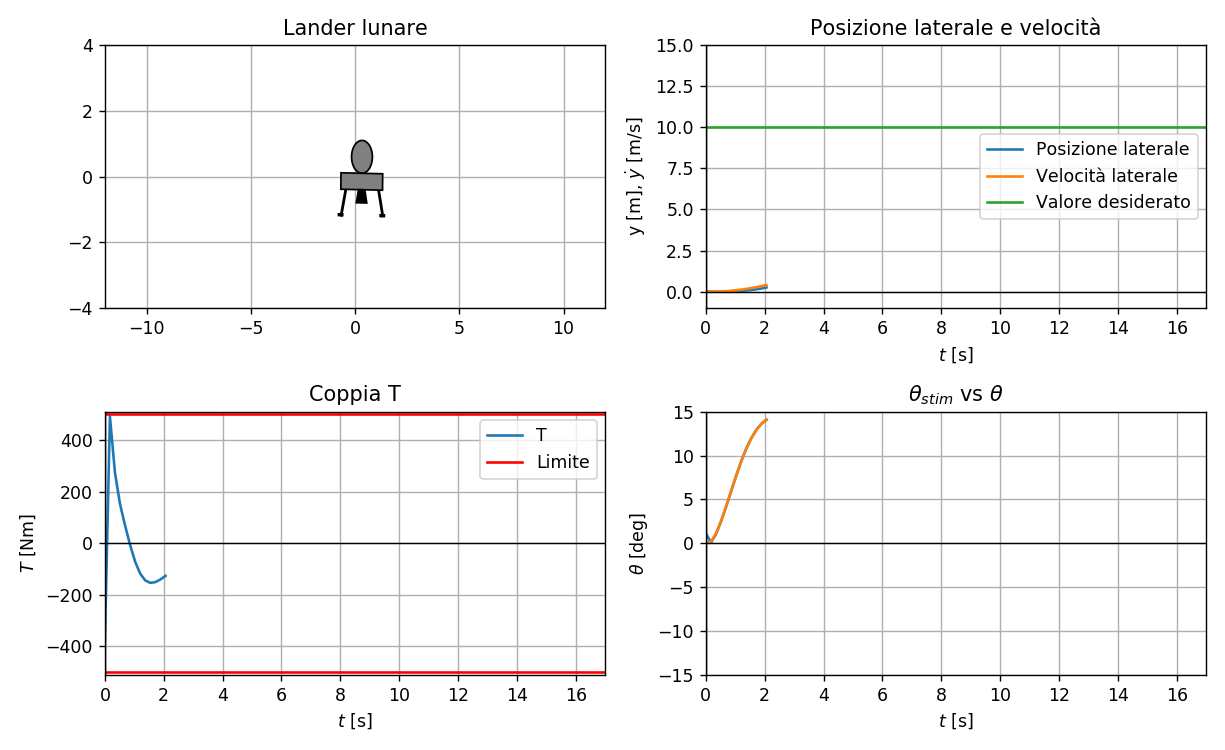

Output()

In [6]:
# Main cell
# Data
global yd, T, yout
yd = 10.
T = []
yout = []

# Figures
fig = plt.figure(num='Simulazione del controllo della posizione laterale del lander lunare')
fig.set_size_inches((9.8, 6))
fig.set_tight_layout(True)

ax0 = fig.add_subplot(221)
ax0.set_title('Lander lunare')
ax0.set_xlim(-12,12)
ax0.set_ylim(-4,4)
ax0.grid()
# ax0.axis('off')

ax1 = fig.add_subplot(222)
linez = ax1.plot([],[])[0]
linezv = ax1.plot([],[])[0]
lined = ax1.plot([],[])[0]
ax1.set_title('Posizione laterale e velocità')
ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('y [m], $\dot y$ [m/s]')
ax1.set_xlim([0,17])
ax1.axvline(x=0,color='black',linewidth=0.8)
ax1.axhline(y=0,color='black',linewidth=0.8)
ax1.grid()
ax1.legend(['Posizione laterale','Velocità laterale','Valore desiderato'])

ax2 = fig.add_subplot(223)
lineu = ax2.plot([],[])[0]
linelimu1 = ax2.plot([],[],'r')[0]
linelimu2 = ax2.plot([],[],'r')[0]
ax2.set_title('Coppia T')
ax2.set_xlabel('$t$ [s]')
ax2.set_ylabel('$T$ [Nm]')
ax2.set_xlim([0,17])
ax2.axvline(x=0,color='black',linewidth=0.8)
ax2.axhline(y=0,color='black',linewidth=0.8)
ax2.grid()
ax2.legend(['T','Limite'])

ax3 = fig.add_subplot(224)
linethetaest = ax3.plot([],[])[0]
linetheta = ax3.plot([],[])[0]
ax3.set_title(r'$\theta_{stim}$ vs $\theta$')
ax3.set_xlabel('$t$ [s]')
ax3.set_ylabel(r'$\theta$ [deg]')
ax3.axvline(x=0,color='black',linewidth=0.8)
ax3.axhline(y=0,color='black',linewidth=0.8)
ax3.set_xlim([0,17])
ax3.grid()

# Patches
rotation_transform = transforms.Affine2D()
circle = patches.Circle((0, 0.6), fill=True, radius=0.5, ec='black', fc='gray', lw=1, zorder=20, 
                        transform=rotation_transform + ax0.transData)
rect = patches.Rectangle((-1, -0.4), 2, 0.5, fill=True, ec='black', fc='gray', lw=1, zorder=20, 
                         transform=rotation_transform + ax0.transData)
poly = patches.Polygon(numpy.stack(([-0.25, -0.15, 0.15, 0.25], [-0.8, -0.4, -0.4, -0.8])).T, 
                       closed=True, fill=True, ec='black', fc='black', lw=1, zorder=20, 
                       transform=rotation_transform + ax0.transData)
lleg = patches.Rectangle((-1, -1.2), 0.05, 1, angle=-15, fill=True, ec='black', fc='black', lw=1, zorder=10, 
                         transform=rotation_transform + ax0.transData)
rleg = patches.Rectangle((1, -1.2), 0.05, 1, angle=15, fill=True, ec='black', fc='black', lw=1, zorder=10, 
                         transform=rotation_transform + ax0.transData)
lfoot = patches.Rectangle((-1.1, -1.2), 0.2, 0.05, fill=True, ec='black', fc='black', lw=1, zorder=20, 
                         transform=rotation_transform + ax0.transData)
rfoot = patches.Rectangle((0.9, -1.2), 0.2, 0.05, fill=True, ec='black', fc='black', lw=1, zorder=20, 
                         transform=rotation_transform + ax0.transData)
ax0.add_patch(circle)
ax0.add_patch(rect)
ax0.add_patch(poly)
ax0.add_patch(lleg)
ax0.add_patch(rleg)
ax0.add_patch(lfoot)
ax0.add_patch(rfoot)
plt.show()

# Functions
def main_function(Ka,La,Ydw,eig1,eig2,eig3,eig4,eig5,eig1o,eig2o,selm,selc,selo,DW):
    global T, yout, yd, Aa, Ba, A11, A21
    method = method_choice(selm)
    eigc, eigo = eigen_choice(selc,selo)
    yd = Ydw
    ax1.set_ylim([-0.1*yd,yd*1.5])
    ax2.set_ylim([-51*yd,51*yd])
    ax3.set_ylim([-15,15])
    
    if method == 1: #Setted matrix gain
        sol = numpy.linalg.eig((Aa-Ba[:,0]*Ka))
        print('Gli autovalori di Aa sono: '+str(round(sol[0][0],3))+', '+str(round(sol[0][1],3))+', '+str(round(sol[0][2],3))+', '+str(round(sol[0][3],3))+' e '+str(round(sol[0][4],3)))
        sol = numpy.linalg.eig(A11+La*A21)
        print('Gli autovalori di A11+La*A21 sono: '+str(round(sol[0][0],3))+' e '+str(round(sol[0][1],3))) 
        sys = simulation(Aa, Ba, Ca, A11, A12, A21, A22, B1, B2, La, Ka, Ta)
        T = numpy.linspace(0, 17, 100)
        T, yout = ctrl.step_response(sys, T, X0a)
    if method == 2: #Setted eigenvalues
        if eigc == 0:
            Ka = ctrl.acker(Aa, Ba[:,0], [eig1[0,0], eig2[0,0], eig3[0,0], eig4[0,0], eig5[0,0]])
            Kaw.setM(Ka)
        if eigc == 2:
            Ka = ctrl.acker(Aa, Ba[:,0], [eig1[0,0], numpy.complex(eig2[0,0],eig2[1,0]), numpy.complex(eig2[0,0],-eig2[1,0]), eig4[0,0], eig5[0,0]])
            Kaw.setM(Ka)
        if eigc == 4:
            Ka = ctrl.acker(Aa, Ba[:,0], [eig1[0,0], numpy.complex(eig2[0,0],eig2[1,0]), numpy.complex(eig2[0,0],-eig2[1,0]), numpy.complex(eig3[0,0],eig3[1,0]), numpy.complex(eig3[0,0],-eig3[1,0])])
            Kaw.setM(Ka)
        if eigo == 0:
            La = numpy.matrix([[0, 2*eig1o[0,0]/3 + 2*eig2o[0,0]/3, 0], [0, -2*eig1o[0,0]*eig2o[0,0]/3, 0]])
            Law.setM(La) 
        if eigo == 2:
            La = numpy.matrix([[0, 2*numpy.complex(eig2o[0,0],eig2o[1,0])/3 + 2*numpy.complex(eig2o[0,0],-eig2o[1,0])/3, 0], [0, -2*numpy.complex(eig2o[0,0],eig2o[1,0])*numpy.complex(eig2o[0,0],-eig2o[1,0])/3, 0]])
            Law.setM(La)
        sol = numpy.linalg.eig((Aa-Ba[:,0]*Ka))
        print('Gli autovalori di Aa sono: '+str(round(sol[0][0],3))+', '+str(round(sol[0][1],3))+', '+str(round(sol[0][2],3))+', '+str(round(sol[0][3],3))+' e '+str(round(sol[0][4],3)))
        sol = numpy.linalg.eig(A11+La*A21)
        print('Gli autovalori di A11+La*A21 sono: '+str(round(sol[0][0],3))+' e '+str(round(sol[0][1],3))) 
        sys = simulation(Aa, Ba, Ca, A11, A12, A21, A22, B1, B2, La, Ka, Ta)
        T = numpy.linspace(0, 17, 100)
        T, yout = ctrl.step_response(sys, T, X0a)

ani = animation.FuncAnimation(fig, fun_animation, init_func=anim_init, frames=100, repeat=True, interval=170, blit=True)


#create dummy widget 
DW = widgets.FloatText(layout=widgets.Layout(width='0px', height='0px'))

#create button widget
START = widgets.Button(
    description='Test',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Test',
    icon='check'
)
                       
def on_start_button_clicked(b):
    #This is a workaround to have intreactive_output call the callback:
    #   force the value of the dummy widget to change
    if DW.value> 0 :
        DW.value = -1
    else: 
        DW.value = 1
    pass
START.on_click(on_start_button_clicked)

# Define type of method 
selm = widgets.Dropdown(
    options= [('Imposta Ka e La','Set Ka and La'), ('Imposta gli autovalori','Set the eigenvalues')],
    value= 'Set Ka and La',
    description='',
    disabled=False
)

# Define the number of complex eigenvalues for the controller
selc = widgets.Dropdown(
    options= [('0 autovalori complessi','0 complex eigenvalues'), ('2 autovalori complessi','2 complex eigenvalues'), ('4 autovalori complessi','4 complex eigenvalues')],
    value= '4 complex eigenvalues',
    description='Aa:',
    style = {'description_width': 'initial'},
    disabled=False
)

# Define the number of complex eigenvalues for the observer
selo = widgets.Dropdown(
    options= [('0 autovalori complessi','0 complex eigenvalues'), ('2 autovalori complessi','2 complex eigenvalues')],
    value= '0 complex eigenvalues',
    description='Aoss:',
    style = {'description_width': 'initial'},
    disabled=False
)

alltogether = widgets.VBox([
    widgets.HBox([
        selm,
        selc,
        selo
    ]),
    widgets.Label('',border=3),
    widgets.HBox([
        widgets.Label('Ka:',border=3),
        Kaw,
        widgets.Label('',border=3),
        widgets.Label('',border=3),
        widgets.Label('La:',border=3),
        Law
    ]),
    widgets.Label('',border=3),
    widgets.HBox([
        widgets.Label('Autovalori di Aa:',border=3),
        eig1, eig2, eig3, eig4, eig5,
        widgets.Label('',border=3),
        widgets.Label('',border=3),
        widgets.Label('Autovalori di Aoss:',border=3),
        eig1o, eig2o
    ]),
    widgets.Label('',border=3),
    widgets.HBox([
        Ydw,
        widgets.Label('',border=3),
        widgets.Label('',border=3),
        widgets.Label('',border=3),
        START
    ])
])

out = widgets.interactive_output(main_function,{'Ka':Kaw, 'La':Law, 'Ydw':Ydw, 'eig1':eig1, 'eig2':eig2, 
                                                'eig3':eig3, 'eig4':eig4, 'eig5':eig5,
                                                'eig1o':eig1o, 'eig2o':eig2o,
                                                'selm':selm, 'selc':selc, 'selo':selo, 'DW':DW})
display(out, alltogether)